In [23]:
import pandas as pd
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

from utils.latex import LatexHelpers

In [24]:
ERROR_METRICS = [
    "MSE",
    "average error",
    "highest error",
    "accuracy",
    "precision (multiclass)",
    "precision (micro)",
    "precision (macro)",
    "recall (multiclass)",
    "recall (micro)",
    "recall (macro)",
    "$F_1$ (multiclass)",
    "$F_1$ (micro)",
    "$F_1$ (macro)",
    "confusion matrix",
]


def add_errors_to_table(
    df_metrics: pd.DataFrame, y_true: pd.Series, y_pred: pd.Series, model_name: str
) -> None:
    if y_true.isna().sum() > 0:
        raise ValueError("y_true contains NaN values")
    if y_pred.isna().sum() > 0:
        raise ValueError("y_pred contains NaN values")

    # MSE
    df_metrics.loc[model_name, ERROR_METRICS[0]] = metrics.mean_squared_error(
        y_true, y_pred
    )
    df_metrics.loc[model_name, ERROR_METRICS[1]] = np.average(y_true - y_pred)
    # highest error
    er = y_true - y_pred
    mx = np.max(er)
    mn = np.min(er)
    df_metrics.loc[model_name, ERROR_METRICS[2]] = int(mn if abs(mn) > mx else mx)
    # accuracy
    df_metrics.loc[model_name, ERROR_METRICS[3]] = metrics.accuracy_score(
        y_true, y_pred
    )
    # precision
    df_metrics.loc[model_name, ERROR_METRICS[4]] = [
        round(float(x), 2)
        for x in metrics.precision_score(y_true, y_pred, average=None, zero_division=0)
    ]
    df_metrics.loc[model_name, ERROR_METRICS[5]] = metrics.precision_score(
        y_true, y_pred, average="micro", zero_division=0
    )
    df_metrics.loc[model_name, ERROR_METRICS[6]] = metrics.precision_score(
        y_true, y_pred, average="macro", zero_division=0
    )
    # recall
    df_metrics.loc[model_name, ERROR_METRICS[7]] = [
        round(float(x), 2) for x in metrics.recall_score(y_true, y_pred, average=None)
    ]
    df_metrics.loc[model_name, ERROR_METRICS[8]] = metrics.recall_score(
        y_true, y_pred, average="micro"
    )
    df_metrics.loc[model_name, ERROR_METRICS[9]] = metrics.recall_score(
        y_true, y_pred, average="macro"
    )
    # F-1
    df_metrics.loc[model_name, ERROR_METRICS[10]] = [
        round(float(x), 2) for x in metrics.f1_score(y_true, y_pred, average=None)
    ]
    df_metrics.loc[model_name, ERROR_METRICS[11]] = metrics.f1_score(
        y_true, y_pred, average="micro"
    )
    df_metrics.loc[model_name, ERROR_METRICS[12]] = metrics.f1_score(
        y_true, y_pred, average="macro"
    )
    df_metrics.loc[model_name, ERROR_METRICS[-1]] = metrics.confusion_matrix(
        y_true, y_pred
    )

/var/folders/ny/50qr5bj563lbm6jm3tks0w400000gn/T/ipykernel_62181/2562723812.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  confusion_matrix = confusion_matrices[j]
/var/folders/ny/50qr5bj563lbm6jm3tks0w400000gn/T/ipykernel_62181/2562723812.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  confusion_matrix = confusion_matrices[j]
/var/folders/ny/50qr5bj563lbm6jm3tks0w400000gn/T/ipykernel_62181/2562723812.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by

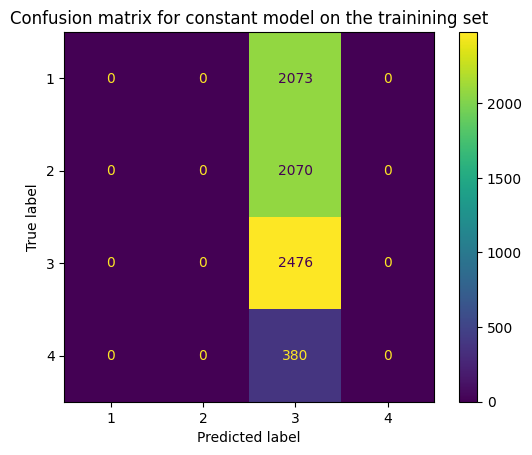

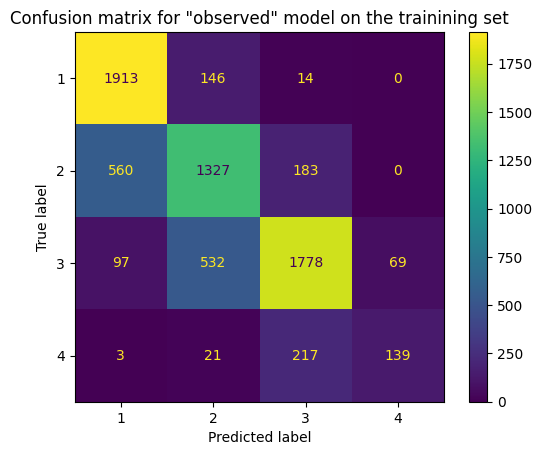

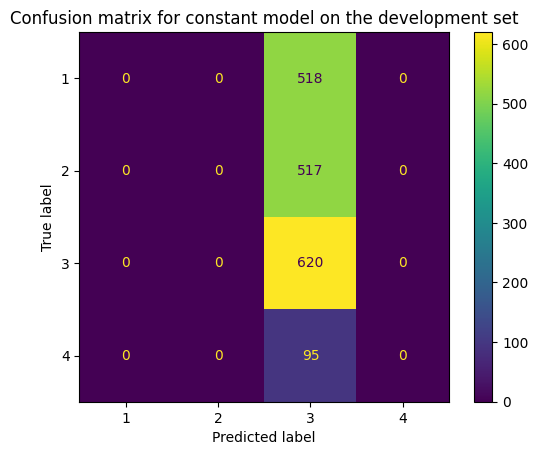

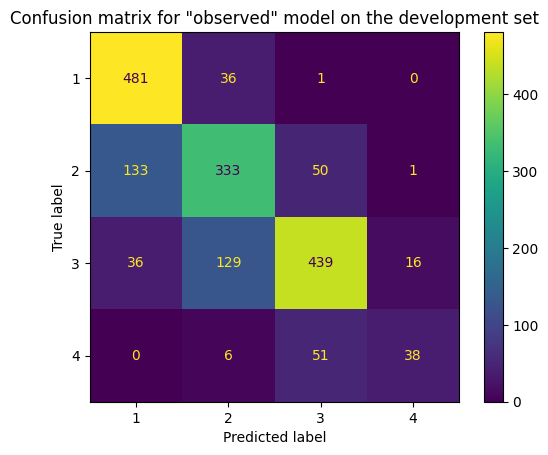

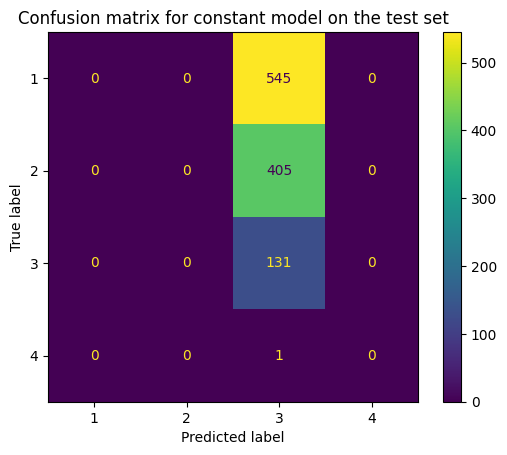

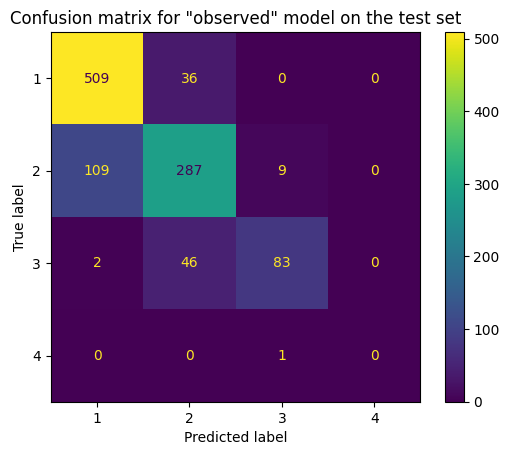

In [25]:
df_train = pd.read_csv("../data/processed/SAIS_train.csv")
df_dev = pd.read_csv("../data/processed/SAIS_dev.csv")
df_test = pd.read_csv("../data/processed/SAIS_test.csv")

classes = sorted(df_train["mapped_hazard_forecast"].unique())
# calculate mean squared error with sikit-learn

df_metrics_train = pd.DataFrame(columns=ERROR_METRICS)
df_metrics_dev = pd.DataFrame(columns=ERROR_METRICS)
df_metrics_test = pd.DataFrame(columns=ERROR_METRICS)

all_sets = [df_train, df_dev, df_test]
all_set_descriptions = ["trainining", "development", "test"]
all_metrics = [df_metrics_train, df_metrics_dev, df_metrics_test]

most_frequent_value = df_train["mapped_hazard_forecast"].value_counts().index[0]

baseline_observed = lambda x: x["mapped_hazard_observed"]
baseline_constant = lambda x: pd.Series(np.zeros(len(x)) + most_frequent_value)

for i, set in enumerate(all_sets):
    y_true = set["mapped_hazard_forecast"]
    add_errors_to_table(all_metrics[i], y_true, baseline_constant(set), "constant")
    add_errors_to_table(all_metrics[i], y_true, baseline_observed(set), '"observed"')

for i in range(len(all_metrics)):
    confusion_matrices = all_metrics[i].iloc[:, -1]
    table = all_metrics[i].iloc[:, :-1].T
    LatexHelpers.save_as_latex_table(
        table,
        name=f"sais_eval_{all_set_descriptions[i]}",
        caption=f"Evaluation metrics computed on the {all_set_descriptions[i]} set",
        path="../tex/assets/tables",
    )
    for j in range(len(confusion_matrices.index)):
        model_name = confusion_matrices.index[j]
        confusion_matrix = confusion_matrices[j]
        disp = metrics.ConfusionMatrixDisplay(
            confusion_matrix=confusion_matrix, display_labels=classes
        )

        disp.plot()
        plt.title(
            f"Confusion matrix for {model_name} model on the {all_set_descriptions[i]} set"
        )
        plt.savefig(
            f"../tex/assets/figures/sais_confusion_matrix_{model_name.replace('"','')}_{all_set_descriptions[i]}.png"
        )